#机器翻译与数据集
机器翻译指的是将序列从一种语言自动翻译成另一种语言。

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
!pip3 install torch torchvision torchaudio

In [9]:
!pip3 install d2l==0.14

     |████████████████████████████████| 48 kB 2.6 MB/s 


In [10]:
import os 
import torch
from d2l import torch as d2l

##下载和预处理数据集
Tatoeba项目的双语句子对组成的“英-法”数据集，数据集中的每一行都是制表符分隔的文本序列对

In [11]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入 "英语-法语" 数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir,'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [12]:
def preprocess_nmt(text):
    """预处理 "英语-法语" 数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i,char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


##词元化

In [13]:
def tokenize_nmt(text, num_examples=None):
    """词元化 "英语-法语" 数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)

In [14]:
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

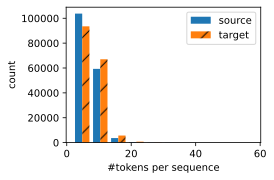

In [15]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _,_,patches = d2l.plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source','target'],'#tokens per sequence','count',source,target);

##词表

In [16]:
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

##加载数据集

In [17]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps] # 截断
    return line + [padding_token] * (num_steps - len(line)) # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [18]:
def build_array_nmt(lines,vocab,num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l,num_steps,vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

##训练模型

In [19]:
def load_data_nmt(batch_size,num_steps,num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text,num_examples)
    src_vocab = d2l.Vocab(source,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = d2l.Vocab(target,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    src_array,src_valid_len = build_array_nmt(source,src_vocab,num_steps)
    tgt_array,tgt_valid_len = build_array_nmt(target,tgt_vocab,num_steps)
    data_arrays = (src_array,src_valid_len,tgt_array,tgt_valid_len)
    data_iter = d2l.load_array(data_arrays,batch_size)
    return data_iter,src_vocab,tgt_vocab

In [20]:
train_iter,src_vocab,tgt_vocab = load_data_nmt(batch_size=2,num_steps=8)
for X,X_valid_len,Y,Y_valid_len in train_iter:
    print('X:',X.type(torch.int32))
    print('X的有效长度:',X_valid_len)
    print('Y:',Y.type(torch.int32))
    print('Y的有效长度:',Y_valid_len)
    break

X: tensor([[ 13,  33,   4,   3,   1,   1,   1,   1],
        [170,   8,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[187,   4,   3,   1,   1,   1,   1,   1],
        [  0,   5,   3,   1,   1,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([3, 3])
